# Power dissipation in Admiralty Inlet

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as netCDF
import cartopy.crs as ccrs
import cmocean.cm as cmo
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import plots

In [2]:
locgrid = 'grid.nc'
# locmodel = '/pong/raid/kthyng/froude/ai65/OUT/'
grid = netCDF.Dataset(locgrid)
pm = grid['pm'][0,0]; pn = grid['pn'][0,0]
dx = pm**-1; dy = pn**-1
h = grid['h'][:]
lon_psi = grid['lon_psi'][:]; lat_psi = grid['lat_psi'][:]
lon_rho = grid['lon_rho'][:]; lat_rho = grid['lat_rho'][:]
dates = pd.date_range("2006-09-01", "2006-10-01", freq="15T")
ntimes = len(dates)
g = 9.81  # m/s^2
Cd = 3e-3  # friction coefficient
rho0 = 1023.7


In [238]:
basesrc = 'savedoutput/'
bc = pd.read_csv(basesrc + 'power_baroclinic_anomaly.csv', index_col=0, parse_dates=True)
bt = pd.read_csv(basesrc + 'power_barotropic_anomaly.csv', index_col=0, parse_dates=True)
o = pd.read_csv(basesrc + 'power_otherterms_correct.csv', index_col=0, parse_dates=True)
z = pd.read_csv(basesrc + 'tidal.csv', index_col=0, parse_dates=True)
# combine other terms from o into bc and bt
bc = pd.concat([bc,o[['Pmix','Pmom','Pfriction']],z['zeta']], axis=1)
bt = pd.concat([bt,o[['Pmix','Pmom','Pfriction']],z['zeta']], axis=1)
# add total diss terms
bc['terms'] = bc['Pmix'] + bc['Pmom'] + bc['Pfriction']
bt['terms'] = bc['Pmix'] + bc['Pmom'] + bc['Pfriction']

## Energy dissipation overall


### Averaging time period for integer number of tidal cycles

In [316]:
z[-29:-28]

,zeta
2006-09-30 17:00:00,0.058906


In [318]:
z[2852:2853]

,zeta
2006-09-30 17:00:00,0.058906


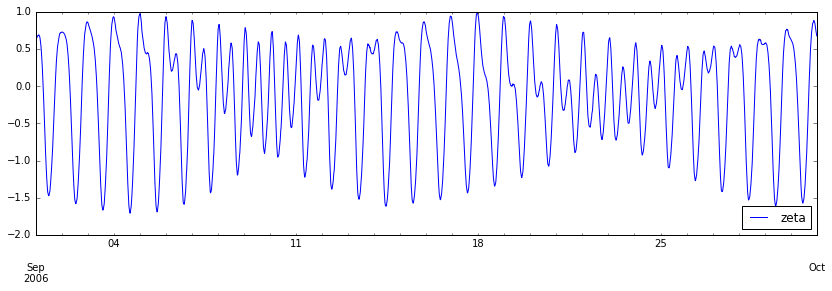

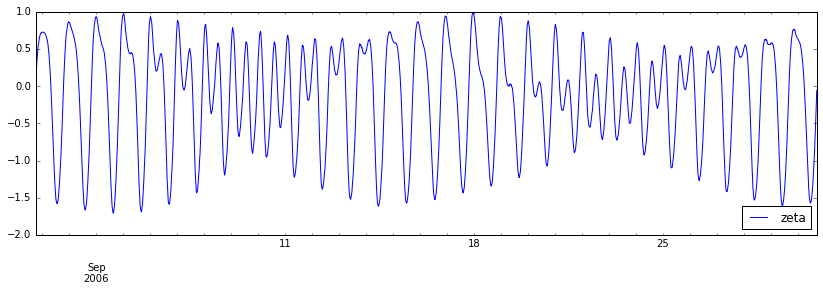

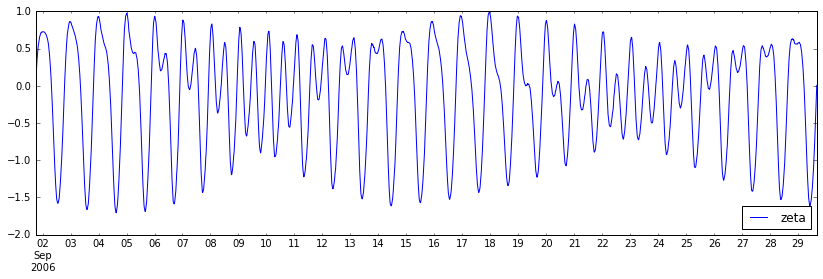

In [250]:
z.plot(figsize=(14,4))
z[72:-29].plot(figsize=(14,4))
z[72:-129+1].plot(figsize=(14,4))
istart = 72; iend = -29

In [50]:
Pbt = bt['P'][istart:iend].mean()/1e6
print()
print('Ratio of mixing to total dissipation: ', bt['Pmix'][istart:iend].mean()/Pbt*100)
print('Ratio of shear production to total dissipation: ', bt['Pmom'][istart:iend].mean()/Pbt*100)
print('Ratio of bottom friction to total dissipation: ', bt['Pfriction'][istart:iend].mean()/Pbt*100)
print('Ratio of diss terms to total: ', bt['terms'][istart:iend].mean()/Pbt*100)


Ratio of mixing to total dissipation:  8079177.78754476
Ratio of shear production to total dissipation:  28570662.108226966
Ratio of bottom friction to total dissipation:  52918899.951009825
Ratio of diss terms to total:  89568739.84678155


In [53]:
Pbc = bt['P'][istart:iend].mean()/1.e6
print('Difference between barotropic and baroclinic energy:', (Pbt-Pbc)/Pbc*100.)

Difference between barotropic and baroclinic energy: 0.0


### Baroclinic vs. barotropic (possibly connect with Arneborg)


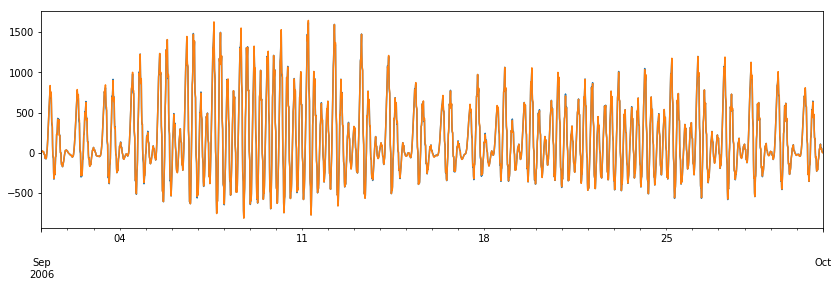

In [12]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(111)
(bc['P']/1e6).plot(ax=ax)
(bt['P']/1e6).plot(ax=ax)

## Dissipation in time

### Lines



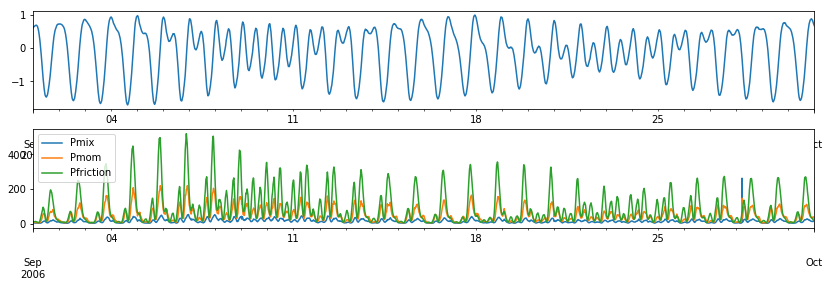

In [55]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(211)
bc['zeta'].plot(ax=ax)
ax = fig.add_subplot(212)
(bc[['Pmix','Pmom','Pfriction']]/1e6).plot(ax=ax)


### In space also

## Subdivide to calculate horizontal viscosity-based loss

In [361]:
dd = 50
istart = 72; iend = -29
dfs = []
for i in range(440)[::dd]:
    if dd == 1:
        dfs.append(pd.read_csv('savedoutput/power/strips' + str(i) + '.csv', index_col=0, parse_dates=True)[istart:iend])
    else:
        dfs.append(pd.read_csv('savedoutput/power/stripsd' + str(dd) + str(i) + '.csv', index_col=0, parse_dates=True)[istart:iend])

In [253]:
dfs[4]['Pmix'].mean()/1e6

2.4298690224412085

In [252]:
# some fixes
if dd == 50:
    dfs[4]['PEwest'] = np.nan
    dfs[4]['KEbtwest'] = np.nan
    dfs[4]['KEbcwest'] = np.nan
    dfs[4]['Pbtwest'] = np.nan
    dfs[4]['Pbcwest'] = np.nan
    dfs[4]['Pbtin'] = -dfs[4]['Pbtnorth']
    dfs[4]['Pbcin'] = -dfs[4]['Pbcnorth']
    dfs[4]['Pbt'] = dfs[4]['Pbtin'] + dfs[4]['Pbtout']
    dfs[4]['Pbc'] = dfs[4]['Pbcin'] + dfs[4]['Pbcout']

    

In [254]:
dfs[4]['KEbtsouth'].mean()/1e6, dfs[4]['KEbtnorth'].mean()/1e6

(-14.319993664533516, -28.37567373848146)

In [256]:
for j, df in enumerate(dfs):
    P = df['Pbt'].mean()
    df['Phor'] = P
    for Pitem in ['Pfriction', 'Pmom', 'Pmix']:
        df['Phor'] -= df[Pitem].mean()

In [218]:
dfs[7].mean()/1e6

PEeast              NaN
KEbteast            NaN
KEbceast            NaN
Pbteast             NaN
Pbceast             NaN
PEwest              NaN
KEbtwest            NaN
KEbcwest            NaN
Pbtwest             NaN
Pbcwest             NaN
PEnorth     -271.913553
KEbtnorth     -8.301326
KEbcnorth     -1.672982
Pbtnorth    -280.214880
Pbcnorth    -273.586536
PEsouth     -270.779218
KEbtsouth     -0.915359
KEbcsouth      4.776248
Pbtsouth    -271.694577
Pbcsouth    -266.002969
Pbtin        280.214880
Pbcin        273.586536
Pbtout      -271.694577
Pbcout      -266.002969
Pbt            8.520303
Pbc            7.583566
Pmix           0.496739
Pmom           1.228982
Pfriction      1.557440
Phor           5.237143
dtype: float64

In [217]:
dfs[8].mean()/1e6

PEeast              NaN
KEbteast            NaN
KEbceast            NaN
Pbteast             NaN
Pbceast             NaN
PEwest              NaN
KEbtwest            NaN
KEbcwest            NaN
Pbtwest             NaN
Pbcwest             NaN
PEnorth     -269.759149
KEbtnorth    -13.417517
KEbcnorth     -8.738874
Pbtnorth    -283.176665
Pbcnorth    -278.498023
PEsouth     -271.913553
KEbtsouth     -8.301326
KEbcsouth     -1.672982
Pbtsouth    -280.214880
Pbcsouth    -273.586536
Pbtin        283.176665
Pbcin        278.498023
Pbtout      -280.214880
Pbcout      -273.586536
Pbt            2.961786
Pbc            4.911487
Pmix           0.570711
Pmom           1.238561
Pfriction      1.729189
Phor          -0.576675
dtype: float64

In [262]:
dfs[4].mean()/1e6

PEeast              NaN
KEbteast            NaN
KEbceast            NaN
Pbteast             NaN
Pbceast             NaN
PEwest              NaN
KEbtwest            NaN
KEbcwest            NaN
Pbtwest             NaN
Pbcwest             NaN
PEnorth     -286.509367
KEbtnorth    -28.375674
KEbcnorth    -23.403090
Pbtnorth    -314.885041
Pbcnorth    -309.912457
PEsouth     -280.956354
KEbtsouth    -14.319994
KEbcsouth    -15.020276
Pbtsouth    -295.276348
Pbcsouth    -295.976630
Pbtin        314.885041
Pbcin        309.912457
Pbtout      -295.276348
Pbcout      -295.976630
Pbt           19.608694
Pbc           13.935827
Pmix           2.429869
Pmom           7.694461
Pfriction     13.921977
Phor          -4.437613
dtype: float64

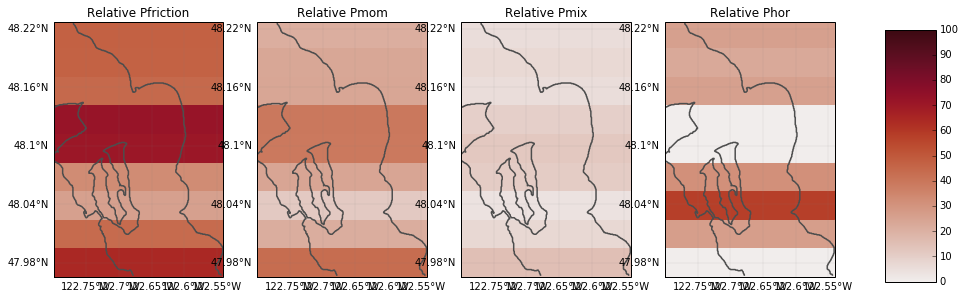

In [257]:
merc = ccrs.Mercator()
pc = ccrs.PlateCarree()
cmap = cmo.amp
whichP = 'bt'
from matplotlib import colors, cm
toplots = ['Pfriction', 'Pmom', 'Pmix', 'Phor']

vmin, vmax = 0, 100
norm = colors.Normalize(vmin, vmax) # the color maps work for [0, 1]

figsize = 14, 7
box = [-122.8, -122.54, 47.9655, 48.227]
fig = plt.figure(figsize=figsize)
# fig.subplots_adjust(top=0.96, bottom=0.02, left=0.06, right=0.82)
for i, toplot in enumerate(toplots):

    ax = fig.add_subplot(1,4,i+1, projection=merc)#, facecolor='0.8')
    ax.set_extent(box, pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-122.8, -122.75, -122.7, -122.65, -122.6, -122.55, -122.5])
    # the following two make the labels look like lat/lon format
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    ax.contour(grid['lon_rho'][:], grid['lat_rho'][:], grid['mask_rho'][:], [0], colors='0.3', transform=pc, linewidths=1.5)
    for j, df in enumerate(dfs):
        if j*dd+dd > lon_psi.shape[0]:
            lon = [lon_psi[j*dd,0], lon_psi[-1,0], lon_psi[-1,-1], lon_psi[j*dd,-1], lon_psi[j*dd,0]]
            lat = [lat_psi[j*dd,0], lat_psi[-1,0], lat_psi[-1,-1], lat_psi[j*dd,-1], lat_psi[j*dd,0]]
        else:
            lon = [lon_psi[j*dd,0], lon_psi[j*dd+dd,0], lon_psi[j*dd+dd,-1], lon_psi[j*dd,-1], lon_psi[j*dd,0]]
            lat = [lat_psi[j*dd,0], lat_psi[j*dd+dd,0], lat_psi[j*dd+dd,-1], lat_psi[j*dd,-1], lat_psi[j*dd,0]]
#         print(lat)

        # plot coastline
        # plot box with color as value from colormap
        # https://stackoverflow.com/questions/15235630/matplotlib-pick-up-one-color-associated-to-one-value-in-a-colorbar
        P = df['P'+whichP].mean()
        Pterm = (df[toplot].mean()/P)*100
        color_i = cmap(norm(Pterm)) # returns an rgba value

        ax.fill(lon, lat, transform=pc, color=color_i)
        ax.set_title('Relative ' + toplot)
cmmapable = cm.ScalarMappable(norm, cmap)
cmmapable.set_array(range(vmin, vmax))
cbar_ax = fig.add_axes([0.95, 0.25, 0.05, 0.5])
fig.colorbar(cmmapable, cax=cbar_ax)

# fig.colorbar(cmmapable, shrink=0.5)


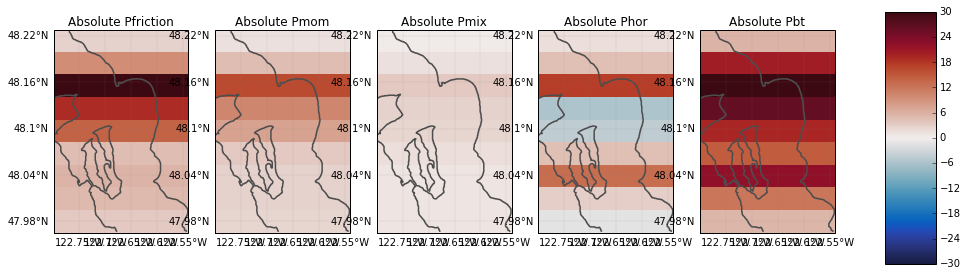

In [258]:
import numpy as np
# Plot each term in absolute 
merc = ccrs.Mercator()
pc = ccrs.PlateCarree()
cmap = cmo.balance
from matplotlib import colors, cm
toplots = ['Pfriction', 'Pmom', 'Pmix', 'Phor', 'P'+whichP]
if dd == 50:
    vmaxs = [30, 30, 30, 30,30]
elif dd == 20:
    vmaxs = [10, 10, 10, 10,10]
elif dd == 10:
    vmaxs = [8, 8, 8, 8,8]
elif dd == 1:
    vmaxs = [.5, .5, .5, .5,.5]
vmin = -vmaxs[0]

figsize = 14, 7
box = [-122.8, -122.54, 47.9655, 48.227]
fig = plt.figure(figsize=figsize)
# fig.subplots_adjust(top=0.96, bottom=0.02, left=0.06, right=0.82)
for i, (vmax, toplot) in enumerate(zip(vmaxs, toplots)):

    norm = colors.Normalize(vmin, vmax) # the color maps work for [0, 1]

    ax = fig.add_subplot(1,5,i+1, projection=merc)#, facecolor='0.8')
    ax.set_extent(box, pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-122.8, -122.75, -122.7, -122.65, -122.6, -122.55, -122.5])
    # the following two make the labels look like lat/lon format
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    ax.contour(grid['lon_rho'][:], grid['lat_rho'][:], grid['mask_rho'][:], [0], colors='0.3', transform=pc, linewidths=1.5)
    for j, df in enumerate(dfs):
        if j*dd+dd > lon_psi.shape[0]:
            lon = [lon_psi[j*dd,0], lon_psi[-1,0], lon_psi[-1,-1], lon_psi[j*dd,-1], lon_psi[j*dd,0]]
            lat = [lat_psi[j*dd,0], lat_psi[-1,0], lat_psi[-1,-1], lat_psi[j*dd,-1], lat_psi[j*dd,0]]
        else:
            lon = [lon_psi[j*dd,0], lon_psi[j*dd+dd,0], lon_psi[j*dd+dd,-1], lon_psi[j*dd,-1], lon_psi[j*dd,0]]
            lat = [lat_psi[j*dd,0], lat_psi[j*dd+dd,0], lat_psi[j*dd+dd,-1], lat_psi[j*dd,-1], lat_psi[j*dd,0]]
#             area = 

        # plot coastline
        # plot box with color as value from colormap
        # https://stackoverflow.com/questions/15235630/matplotlib-pick-up-one-color-associated-to-one-value-in-a-colorbar
#         P = df['Pbc'].mean()
#         Pterm = (df[toplot].mean()/P)*100
        Pterm = df[toplot].mean()/1e6
        color_i = cmap(norm(Pterm)) # returns an rgba value

        ax.fill(lon, lat, transform=pc, color=color_i)
        ax.set_title('Absolute ' + toplot)
cmmapable = cm.ScalarMappable(norm, cmap)
cmmapable.set_array(np.linspace(vmin, vmax, 10))
cbar_ax = fig.add_axes([0.95, 0.25, 0.05, 0.5])
fig.colorbar(cmmapable, cax=cbar_ax)

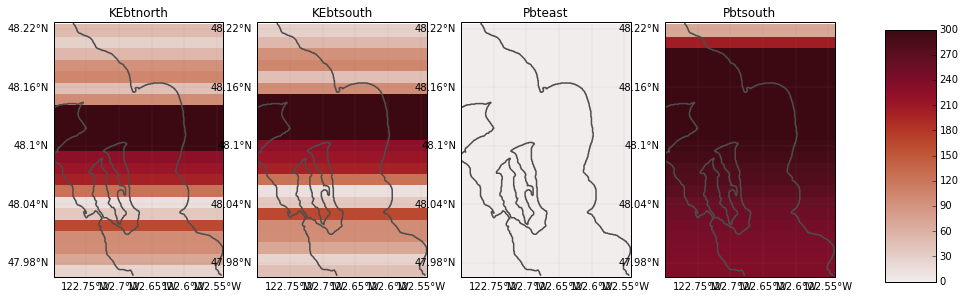

In [226]:
import numpy as np
# Plot each term in absolute 
merc = ccrs.Mercator()
pc = ccrs.PlateCarree()
cmap = cmo.amp
from matplotlib import colors, cm
toplots = ['KE'+whichP+'north', 'KE'+whichP+'south', 'P'+whichP+'east', 'P'+whichP+'south']
if dd == 50:
    vmaxs = [50, 50,500, 500]
elif dd == 20:
    vmaxs = [20, 20, 300, 300]
elif dd == 10:
    vmaxs = [5, 5, 5, 5]
elif dd == 1:
    vmaxs = [.5, .5, .5, .5]
vmin = 0

figsize = 14, 7
box = [-122.8, -122.54, 47.9655, 48.227]
fig = plt.figure(figsize=figsize)
# fig.subplots_adjust(top=0.96, bottom=0.02, left=0.06, right=0.82)
for i, (vmax, toplot) in enumerate(zip(vmaxs, toplots)):

    norm = colors.Normalize(vmin, vmax) # the color maps work for [0, 1]

    ax = fig.add_subplot(1,4,i+1, projection=merc)#, facecolor='0.8')
    ax.set_extent(box, pc)
    gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-122.8, -122.75, -122.7, -122.65, -122.6, -122.55, -122.5])
    # the following two make the labels look like lat/lon format
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False  # turn off labels where you don't want them
    gl.ylabels_right = False
    ax.contour(grid['lon_rho'][:], grid['lat_rho'][:], grid['mask_rho'][:], [0], colors='0.3', transform=pc, linewidths=1.5)
    for j, df in enumerate(dfs):
        if j*dd+dd > lon_psi.shape[0]:
            lon = [lon_psi[j*dd,0], lon_psi[-1,0], lon_psi[-1,-1], lon_psi[j*dd,-1], lon_psi[j*dd,0]]
            lat = [lat_psi[j*dd,0], lat_psi[-1,0], lat_psi[-1,-1], lat_psi[j*dd,-1], lat_psi[j*dd,0]]
        else:
            lon = [lon_psi[j*dd,0], lon_psi[j*dd+dd,0], lon_psi[j*dd+dd,-1], lon_psi[j*dd,-1], lon_psi[j*dd,0]]
            lat = [lat_psi[j*dd,0], lat_psi[j*dd+dd,0], lat_psi[j*dd+dd,-1], lat_psi[j*dd,-1], lat_psi[j*dd,0]]

        # plot coastline
        # plot box with color as value from colormap
        # https://stackoverflow.com/questions/15235630/matplotlib-pick-up-one-color-associated-to-one-value-in-a-colorbar
#         P = df['Pbc'].mean()
#         Pterm = (df[toplot].mean()/P)*100
        Pterm = abs(df[toplot].mean()/1e6)
#         print(Pterm)
        color_i = cmap(norm(Pterm)) # returns an rgba value

        ax.fill(lon, lat, transform=pc, color=color_i)
        ax.set_title(toplot)
cmmapable = cm.ScalarMappable(norm, cmap)
cmmapable.set_array(np.linspace(vmin, vmax, 10))
cbar_ax = fig.add_axes([0.95, 0.25, 0.05, 0.5])
fig.colorbar(cmmapable, cax=cbar_ax)

In [204]:
abs((grid['x_psi'][j*dd,0] - grid['x_psi'][j*dd,-1]) * (grid['y_psi'][j*dd,0] - grid['y_psi'][j*dd+dd,0]))

12507921.356776681

In [205]:
grid['x_psi'][j*dd,0] - grid['x_psi'][j*dd,-1]

-19229.612717087835

In [290]:
df = dfs[1]
dfsum = df.sum()
dfsum

PEeast       0.000000e+00
KEbteast     0.000000e+00
KEbceast     0.000000e+00
Pbteast      0.000000e+00
Pbceast      0.000000e+00
PEwest       0.000000e+00
KEbtwest     0.000000e+00
KEbcwest     0.000000e+00
Pbtwest      0.000000e+00
Pbcwest      0.000000e+00
PEnorth     -6.632557e+11
KEbtnorth   -2.925758e+10
KEbcnorth   -3.055254e+10
Pbtnorth    -6.925133e+11
Pbcnorth    -6.938082e+11
PEsouth     -6.443130e+11
KEbtsouth   -1.586499e+10
KEbcsouth   -9.462440e+09
Pbtsouth    -6.601780e+11
Pbcsouth    -6.537754e+11
Pbtin        6.925133e+11
Pbcin        6.938082e+11
Pbtout      -6.601780e+11
Pbcout      -6.537754e+11
Pbt          3.233532e+10
Pbc          4.003283e+10
Pmix         2.298151e+09
Pmom         7.058235e+09
Pfriction    1.427183e+10
Phor         8.707104e+09
dtype: float64

In [291]:

(dfsum['Pbtin'] + dfsum['Pbtout'] - dfsum['Pmix'] - dfsum['Pmom'] - dfsum['Pfriction'])/1e9

8.7071039713727991

In [292]:
dfsum['Pbt']/1e9

32.33531759734997

In [296]:
df['Pbt'][10]/1e6

6.3682255861767523

In [298]:
    (df['Pbtin'][10] + df['Pbtout'][10] - df['Pmix'][10] - df['Pmom'][10] - df['Pfriction'][10])/1e6

6.3682255861767532

In [299]:
dfm = df.mean()
dfm

PEeast                NaN
KEbteast              NaN
KEbceast              NaN
Pbteast               NaN
Pbceast               NaN
PEwest                NaN
KEbtwest              NaN
KEbcwest              NaN
Pbtwest               NaN
Pbcwest               NaN
PEnorth     -2.473912e+08
KEbtnorth   -1.091294e+07
KEbcnorth   -1.139595e+07
Pbtnorth    -2.583041e+08
Pbcnorth    -2.587871e+08
PEsouth     -2.403256e+08
KEbtsouth   -5.917565e+06
KEbcsouth   -3.529444e+06
Pbtsouth    -2.462432e+08
Pbcsouth    -2.438551e+08
Pbtin        2.583041e+08
Pbcin        2.587871e+08
Pbtout      -2.462432e+08
Pbcout      -2.438551e+08
Pbt          1.206092e+07
Pbc          1.493205e+07
Pmix         8.571992e+05
Pmom         2.632687e+06
Pfriction    5.323322e+06
Phor         3.247708e+06
dtype: float64

In [300]:
(dfm['Pfriction']+dfm['Pmom']+dfm['Pmix'])/1e6

8.8132091107710941

In [303]:
dfo = pd.read_csv('savedoutput/power_otherterms_correct.csv', index_col=0, parse_dates=True)

In [306]:
dfom = dfo.mean()
dfom


Pin         -5.146897e+06
Pout         2.783246e+06
P           -2.363652e+06
Pmix         1.402159e+07
Pmom         4.958613e+07
Pfriction    9.181148e+07
dtype: float64

In [307]:
(dfom['Pfriction']+dfom['Pmom']+dfom['Pmix'])/1e6

155.41920069616407

In [313]:
(z-z.mean()).sum()

zeta    4.152234e-14
dtype: float64

In [322]:
dfos = dfo.sum()

In [321]:
dfb = pd.read_csv('savedoutput/power_barotropic.csv', index_col=0, parse_dates=True)
dfbs = dfb[72:2852].sum()
dfbs

PEwest    -1.780778e+13
KEwest    -4.501830e+09
PEnorth   -2.719330e+12
KEnorth   -9.012544e+09
PEsouth   -7.234182e+12
KEsouth   -6.435125e+09
Pwest     -1.781228e+13
Pnorth    -2.728343e+12
Psouth    -7.240617e+12
Pin       -1.508394e+13
Pout      -7.240617e+12
P         -2.232456e+13
dtype: float64

In [326]:
(dfbs['P'] - dfos['Pmix'] - dfos['Pmom'] - dfos['Pfriction'])/1e9

-22772.319237180473

In [329]:
dfb['Pin'][10] + dfb['Pout'][10] - dfo['Pfriction'][10] - dfo['Pmom'][10] - dfo['Pmix'][10]

-17718229587.971622

In [332]:
dfb['Pin'][10] +dfb['Pout'][10]

-17699181321.084625

In [370]:
df = dfs[0]
dfsum = df.mean()

In [371]:
(dfsum['Pbtin'] + dfsum['Pbtout'] - dfsum['Pfriction'] - dfsum['Pmom'] - dfsum['Pmix'])/1e6

-1.4310677626406878

In [374]:
(df['Pbtin']+df['Pbtout']-df['Pfriction']-df['Pmom']-df['Pmix'])[29:-24]

2006-09-02 01:15:00   -1.654295e+05
2006-09-02 01:30:00    3.355385e+05
2006-09-02 01:45:00    3.577141e+05
2006-09-02 02:00:00    6.778589e+05
2006-09-02 02:15:00    5.926727e+05
2006-09-02 02:30:00   -7.635471e+05
2006-09-02 02:45:00   -9.216015e+05
2006-09-02 03:00:00   -1.274785e+06
2006-09-02 03:15:00   -6.220174e+05
2006-09-02 03:30:00   -3.353635e+06
2006-09-02 03:45:00   -3.243497e+06
2006-09-02 04:00:00   -3.705535e+06
2006-09-02 04:15:00   -2.807631e+06
2006-09-02 04:30:00   -6.792841e+06
2006-09-02 04:45:00   -6.033837e+06
2006-09-02 05:00:00   -6.155255e+06
2006-09-02 05:15:00   -3.579787e+06
2006-09-02 05:30:00   -6.281196e+06
2006-09-02 05:45:00   -3.830951e+06
2006-09-02 06:00:00   -2.035003e+06
2006-09-02 06:15:00   -4.726257e+04
2006-09-02 06:30:00    1.102336e+06
2006-09-02 06:45:00    4.450821e+06
2006-09-02 07:00:00    7.621371e+06
2006-09-02 07:15:00    7.081249e+06
2006-09-02 07:30:00    1.211886e+07
2006-09-02 07:45:00    1.668093e+07
2006-09-02 08:00:00    2.088